In [2]:
import numpy as np
import pandas as pd
import statistics as st
import scipy.stats as stats
from scipy.stats import norm,chisquare
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.utils import shuffle
import random
import collections

In [4]:
Data = pd.read_csv("cern_datasets_z_ee_mass.csv")
df = pd.DataFrame(Data)
ZM = np.array(Data)
ZM = ZM[:,0]
#with pd.option_context('display.max_rows', -1, 'display.max_columns', 5):
#    print(df)

In [19]:
df.head()

,Z_mass(GeV)
0,89.120279
1,88.596531
2,86.301632
3,84.503178
4,95.679594


###### Splitting the data into two arrays:

In [11]:
data1 = []
data2 = []
for i in range(len(Data)):
    if Data['Z_mass(GeV)'][i] > 90:
        data1.append(Data['Z_mass(GeV)'][i])
    elif Data['Z_mass(GeV)'][i] <= 90:
        data2.append(Data['Z_mass(GeV)'][i])
print("The len of data for greater than 90 GeV is %d, while\
 max value \n is %d" %(len(data1),max(data1)))
print("The len of data for greater than 90 GeV is %d, while\
 max value \n is %d" %(len(data2),max(data2)))

The len of data for greater than 90 GeV is 181, while max value 
 is 176
The len of data for greater than 90 GeV is 482, while max value 
 is 89


In [6]:
def descriptiveSTATS(Data):
    #will find the descriptive statistics of the data inputted into this function
    deviation = st.stdev(Data)
    Mean = np.mean(Data)
    variance = st.variance(Data)
    median = st.median(Data)
    skew = stats.skew(Data)
    events = len(Data)
    return([deviation,Mean,variance,median,skew,events])

def descriptiveSTATSpandaframe(Data,index):
    #Enter your descriptions of the type of resistor/ name of the variables one is performing descriptive statistics
    #for
    InitializeFrame = {'Standard Deviation':Data[0],
                      'Mean':Data[1],
                      'Variance':Data[2],
                      'Median':Data[3],
                      'Skew':Data[4],
                      'Events':Data[5]}
    Frame = pd.DataFrame(InitializeFrame,index)
    return(Frame)
desc = descriptiveSTATS(ZM)
descf = descriptiveSTATSpandaframe(desc, ['Z-ee Mass'])
descf

,Standard Deviation,Mean,Variance,Median,Skew,Events
Z-ee Mass,27.140589,74.674579,736.611577,86.774291,-1.254704,663


0) From this data I have learned that the data is averaging a mass of 74.67 with a standard deviation 27.14. Suggesting that the gaussian distribution of this data, will not be precise. Also notice that the skew of the data is skewed to the left, suggesting that there is a greater weight from the left hand side of a guassian distribution. 

# Frequency Plot
We can determine the width of the bins, such that the uncertainty will be below 10$\%$. In this case, the uncertainty is 9$\%$. We can find the uncertainty by the following method: 
\begin{equation} 
fractionalUncertainty = \frac{\delta x}{x_{best}}
\end{equation}
Where $\delta x$ (or absolute uncertainty) = 4.413 for this case. Which is calculated by taking the actual value - measured value. 

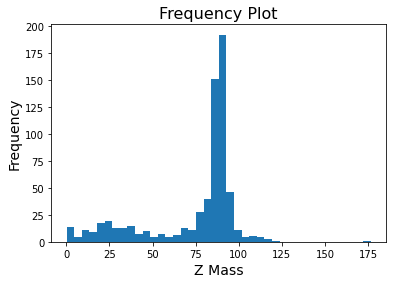

In [12]:
binwidth_stats = np.histogram_bin_edges(ZM, bins = 'fd') #note the binwidth is the uncertainty = 4.4 between eachvalue

freq, edges = np.histogram(ZM, bins = binwidth_stats)
freq = freq[:28]

arb = []
for l, r in zip(edges[:-1], edges[1:]):
    arb.append((ZM[(ZM > l) & (ZM < r)]))
val = []
for i in range(len(arb)):
    if len(arb[i])!=0:
        val.append(sum(arb[i])/len(arb[i]))
    else: 
        val.append(0)
val = np.array(val)
val = val[:28]


plt.hist(ZM, bins = binwidth_stats)
plt.title("Frequency Plot",fontsize = 16)
plt.xlabel('Z Mass',fontsize = 14)
plt.ylabel('Frequency',fontsize = 14)
plt.show()

### Gaussian
Now, it is obvious that the data set follows a normal distribution, and by the central limit theorem. It states that the population with mean $\mu$ and standard deviation $\sigma$, then the distribution of the sample means will be approximately normally distributed. 

The two important fit parameters that we need to consider is the mean and the standard deviation, such that these two parameters will determine the confidence level of our data and also the precision. 

Overlaying the gaussian curve we will use a non-linear fit least squares fit to an effective range. From this fit we will extract the mean and the standard deviation from its parameters. The yield of the plot is as follows: 

#### Applying a non-linear fit squares fit to an effective range 
The parameters yielded of the gaussian distribution are as follows: 
$\mu$ = 88.83 
$\sigma$ = 3.43

In [14]:
def gaussian_fit(x,y):
    y = y[11:]
    x = x[11:]
    mu, std = norm.fit(y)
    def gauss_function(x, a, x0, sigma):
        return(a*np.exp(-(x-x0)**2/(2*sigma**2)))
    params, pcov = curve_fit(gauss_function, x,y, p0 = [1, mu, std])

    CHI, pvalue = chisquare(y, gauss_function(x,*params),3)
    #print("Chisquare = %.3f"%(CHI))

    gaussfit = gauss_function(x,*params)
    return(gaussfit,params)
y, params = gaussian_fit(val,freq)

#### Overlaying the histogram with a normal distribution of the data
The parameters are given from the gaussian fit.<br> 
The orange curve is the normal distributed curve using the paramters of the curve_fit. We can see that the normally distributed curve, does not have a sharp and an abnormal spike at the top of the curve. This is the case, because there aren't enough data points in between the frequency points to have a smooth curve, thus causing the spike in the curve fit. 

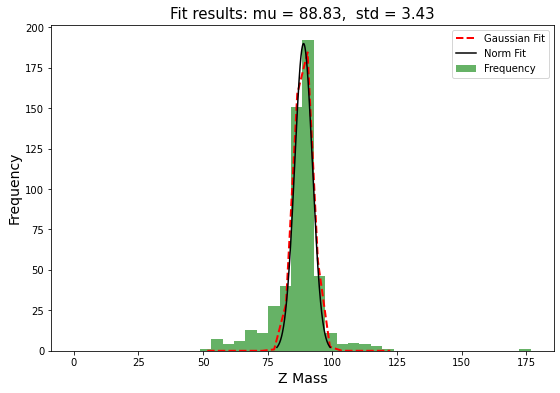

In [15]:
Z = sorted(ZM)
Zm = Z[135:]
VAL = val[11:]
FREQ = freq[11:]
plt.figure(figsize = (9,6))

plt.hist(Zm, bins=binwidth_stats,alpha=0.6, color='g')
plt.plot(VAL,y, '--r', linewidth = 2)

mu = params[1]
sigma = params[2]
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
p = stats.norm.pdf(x, mu, sigma)*params[0]*8
plt.plot(x, p, '-', color = 'black')
title = "Fit results: mu = %.2f,  std = %.2f" % (params[1], params[2])
plt.title(title,fontsize = 15)
plt.xlabel('Z Mass',fontsize = 14)
plt.ylabel('Frequency',fontsize = 14)
plt.legend(["Gaussian Fit",'Norm Fit','Frequency'])
plt.show()

### Dealing with background:
Note: I will try to another non-linear least squares fit. "The Lorentzian Peak on Quadratic Background"
\begin{equation}
y(E) = a_1 + a_2 +a_3E^2 + A_o\frac{\Gamma_o/(2\pi)}{(E-E_o)^2 +(\Gamma_0/2)^2} 
\end{equation}  

[ 1.24641911e-01  5.36300267e-02 -5.32282725e-04  2.36169792e+02
  8.91008170e+01  6.73364407e+00]
Chi-square =  251.24797362037813
Probability = 1.00000


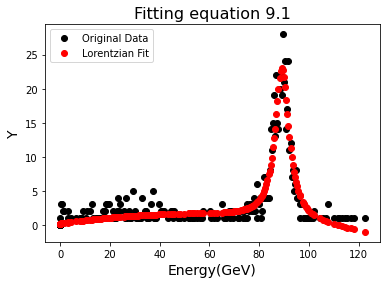

In [18]:
freq2, edges2 = np.histogram(ZM, bins = 400)
arb2 = []
for l, r in zip(edges2[:-1], edges2[1:]):
    arb2.append((ZM[(ZM > l) & (ZM < r)]))
val2 = []
for i in range(len(arb2)):
    if len(arb2[i])!=0:
        val2.append(sum(arb2[i])/len(arb2[i]))
    else: 
        val2.append(0)
val2 = np.array(val2)
VAL2 = val2[150:]
FREQ2 = freq2[150:]

def Lorentzian_fit(x,y): 
    def func(E,a1,a2,a3,a4,a5,a6):
        numerator = a6/(2*np.pi)
        denom = (E - a5)**2 + (a6/2)**2
        return(a1 + a2*E + a3*E**2 + a4*(numerator/denom))
    
    params1,pcov1 = curve_fit(func,  x,  y, p0 = (1 ,1 ,1 ,1 ,90 , 1))

    
    fit1 = func(x,*params1)

    print(params1)
    #Find the pearson correlation: R^2 
    
    #Finding chi-square and the probability 
    CHI, pvalue = chisquare(y,fit1,6)
    
    print("Chi-square = ", CHI)
    print('Probability = %.5f' %(pvalue))

    plt.plot(x,y,'ko')
    plt.plot(x,fit1,'ro')
    plt.title('Fitting equation 9.1', fontsize = 16)
    plt.xlabel("Energy(GeV)", fontsize = 14)
    plt.ylabel('Y', fontsize =14)
    plt.legend(['Original Data', 'Lorentzian Fit'])
    plt.show()
    return
Lorentzian_fit(val2,freq2)

From the lorentzian fit, we see that the $\mu$ = 89.03GeV and $\sigma$=7.09.<br>
We see that the parameters are only slighly altered by comparing only the values that have correlation, the mean is not altered much, but the standard deviation is altered.<br>
Notice, that the standard Deviation increases, we should expect a higher standard deviation, in that we are removing information from our data. Hence the standard deviation will increase, due to the difference between the values will increase. <br>
The Chi-squared value improves, relativiely, due to the fact that in the region of interest the data is improving in predicting the observed value to the expected. Thus, chi-squared will reduce. 

#### invariant mass of the Z from the dilepton decay = 89.03 $\pm$ 7.03 GeV
The expected value of the Z-mass is 91.1876 $\pm$ .0021 GeV.<br>

The error percentage between Z-mass expected and calcuated is 2.4$\%$. Though, our error margins are within the expected value, such that we are encompassing the correct answer. However, we can improve our measured value, by having more data to improve the peak. Or we can increase the number of bins in the histogram plot, such that the peak will sit in a bin of approximately a size of $\delta x$. 

### 200 random events
In taking 200 random events, there is not enough information to fi the data to a nice peak of about 89GeV because the frequency events increase for the events away from the average compared to the above events.

In [8]:
Z11 = random.choices(ZM, k=200)
Z11 = np.array(Z11)

[-1.38625561e-01  4.35164504e-02  1.39318487e-03 -1.34403456e+04
  6.66888148e+03 -1.28586066e+04]
Chi-square =  244.87573848618456
Probability = 0.00000


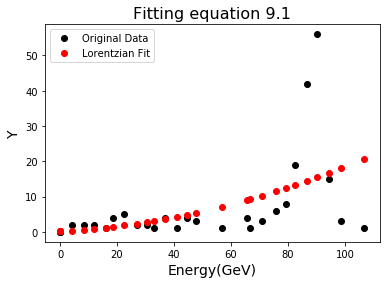

Text(0.5, 1.0, 'Frequency Plot of Rand 200 Events')

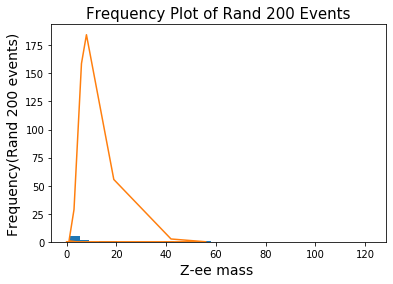

In [26]:
binwidth_stats11 = np.histogram_bin_edges(Z11, bins = 'fd')

freq11, edges11 = np.histogram(Z11, bins = binwidth_stats11)
freq11 = freq11[:28]

arb11 = []
for l, r in zip(edges11[:-1], edges11[1:]):
    arb11.append((Z11[(Z11 > l) & (Z11 < r)]))
val11 = []
for i in range(len(arb11)):
    if len(arb11[i])!=0:
        val11.append(sum(arb11[i])/len(arb11[i]))
    else: 
        val11.append(0)
val11 = np.array(val11)
val11 = val11[:28]
Lorentzian_fit(val11,freq11)
y2, params2 = gaussian_fit(val,freq)
plt.hist(freq11[11:],bins = binwidth_stats11 )
plt.plot(freq11[11:],y2)
plt.ylabel('Frequency(Rand 200 events)',fontsize = 14)
plt.xlabel('Z-ee mass ',fontsize = 14)
plt.title("Frequency Plot of Rand 200 Events", fontsize = 15)